# Image Filtering

The main objectives of this module are:

* Implement point filtering with look-up tables.
* Implement region filtering with kernel convolution, morphological operations and edge detection.
* Understand spatial frequency information with the Fourier transform.

## 1. Look-up tables

Look-up tables are a very useful tool to perform simple pixel-level filtering of an image.

Numpy arrays indexing ([see reference here](http://docs.scipy.org/doc/numpy/user/basics.indexing.html)) is a very powerful tool, but can be a bit counter-intuitive at first. We will use it to quickly create and use look-up tables to transform an image.

Look at the short example below. 

We construct an image with 4 possible values for each pixel (-> $I(x,y) \in \{0,1,2,3\}$). We then build the following LUT:

|Input value|Output value|
|--|--|
|0|2|
|1|3|
|2|1|
|3|0|

And we apply it on the image.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Let's create a 3x3 "image" with 4 possible pixel values (in [0,3])
im = np.array([[1,0,2],[2,1,3],[3,3,1]])

# look-up table is a vector of size 4 mapping the new value for the pixels of m
lut = np.array([2,3,1,0]) # maps 0 -> 2, 1 -> 3, 2 -> 1, 3 -> 0

plt.figure(figsize=(8,2))
plt.plot(lut)
plt.title('Look-up table')
plt.show()

# we can use numpy vector indexing to apply the look-up table:
new_im = lut[im] # This will create a new array with the same size as m

plt.figure(figsize=(8,4))
plt.subplot(1,2,1) #supblot is useful to display images side-by-side
plt.imshow(im, cmap=cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(new_im, cmap=cm.gray)
plt.title('LUT(Original)')
plt.show()

**Starting from this example, create the following LUTs** and apply them to the "walking.jpg" image:
1. For inverting an image (so that $0 \rightarrow 255$, $255 \rightarrow 0$)
1. To keep only graylevel such that $g \ge t$, setting all other values to 0.
1. To reduce the number of gray levels from 256 to 8 (so that $255 \rightarrow 7$, $0 \rightarrow 0$).
1. To "stretch" the histogram so that, given a **minimum value** $T_{min}$ and a **maximum value** $T_{max}$, we have :
    * If $I(x,y) < T_{min}$, the new value is set to 0
    * If $I(x,y) > T_{max}$, the new value is set to 255
    * Values between $T_{min}$ and $T_{max}$ are stretched to cover the entire histogram.
1. to perform an **equalization** of the cameraman image (so that the histogram becomes "as flat as possible")

In [ ]:
from skimage.io import imread,imshow,imsave

im = imread('walking.jpg')
print(im.shape, im.dtype)
plt.figure(figsize=(10,10))
plt.show()

## -- Your code here -- ##


## -- Inverting table -- ##
lut_inv = np.zeros(256)
for i in range(256):
    lut_inv[i] = i

lut_inv =  abs(lut_inv - 255)

inv_im = lut_inv[im]
# imshow(inv_im, cmap=cm.gray)

## -- Treshold of graylevel -- ## 
res = 256
val = 100
# val = int(input('Valeur stp'))
tresh_lutA = np.zeros( val)
tresh_lutB = np.zeros(res - val)
for i in range( res - val):
    tresh_lutB[i] = i + val

tresh_lut = np.hstack((tresh_lutA, tresh_lutB))
tresh_im = tresh_lut[im]
# imshow(tresh_im, cmap = cm.gray)

## -- Reduction of resolution -- ## 
oldD = 256
newD = 8
lut_ld = np.zeros(256)
for i in range(256):
    lut_ld[i] = int(i/(oldD/newD))
ld_im = lut_ld[im]
# imshow(ld_im, cmap = cm.gray)    

## -- Stretch -- #
res = 256
Tmax = 200
Tmin = 40
if(Tmin > Tmax):
    print('Erreur, Tmin > Tmax')
    
lut_Sa = np.zeros(Tmin)
lut_Sb = np.zeros(Tmax - Tmin)
lut_Sc = np.ones(res - Tmax) * 255

for i in range(Tmax - Tmin):
    lut_Sb[i] = int(i * ( res / (Tmax-Tmin) ))    

lut_S = np.hstack((lut_Sa, lut_Sb, lut_Sc))
print(lut_S.shape)
S_im = lut_S[im]
imshow(S_im, cmap = cm.gray)

## -- Equalization -- ##

# plt.hist(im.ravel(),256,[0,255],True,None)

cumul_hist = np.zeros(256)
c = 0 
for v in range(256):
    c += (im==v).sum()
    cumul_hist[v] = c
cumul_hist /= cumul_hist.max()

h = cumul_hist
lut_eq = (255*h).astype('uint8')
# plt.plot(lut_eq)
eq_im = lut_eq[im]
# imshow(eq_im, cmap = cm.gray)

# -- LUT print -- #
# plt.plot(lut_S)

**Need more help? You can check the following videos:**

* [Look-Up Tables](https://www.youtube.com/watch?v=PHiiKoSsVac&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=13)
* [Auto-levels](https://www.youtube.com/watch?v=DLN4jfBJakQ&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=14)
* [Equalization](https://www.youtube.com/watch?v=C44WuMUudik&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=15)

## 2. Kernel convolution

Kernal convolution allows us to filter an image based on the values of a neighborhood.

Write a program that applies a 3x3 kernel convolution on an image. Use it on the "walking" image to perform a mean filter.

In [ ]:


im = imread('walking.jpg')
# imshow(im)
# print(im.shape[0], im.shape[1])

## -- Your code here -- ##

def conv_3x3(region, kernel, i, j):
    sum = 0
    for k in [-1,0,1]:
        for l in [-1,0,1]:
            sum += region[i + k, j + l]*kernel[k,l]        
    return sum
    
def conv(im, kernel): 
    im_out = np.zeros(im.shape)
    for i in range(im.shape[0]-1):
        for j in range(im.shape[1]-1):
            if(i != 0 and j!= 0):
                im_out[i,j] = conv_3x3(im,kernel,i,j)
            
            
    return im_out
kernel = np.array([[1, 1, 1],[0, 0, 0],[-1, -1, -1]]).astype('float') 
conv_im = conv(im, kernel)        
imshow(conv_im,cmap = cm.gray)  


Using the [median filter](https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#skimage.filters.rank.median) and the [mean filter](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.mean) from scikit-image, compare the behaviour of the two filters with neighborhood of increasing sizes on the "noisy" astronaut image:

In [ ]:
# import skimage.morphology
from skimage.filters.rank import mean, median
from skimage.morphology import disk,square 

im = imread('astronaut_noisy.jpg')
# imshow(im)

## -- Median -- ## 

ksize = 5
im_med = np.zeros(im.shape)

# for i in range(ksize//2, im.shape[0]-ksize//2):
#     for j in range(ksize//2, im.shape[1]-ksize//2):
#         im_med[i,j] = median(im[i-ksize//2: i+ksize//2 +1 , j-ksize//2: j+ksize//2 +1])
im_med = median(im, disk(5))

## -- Mean -- ##

im_mean = np.zeros(im.shape)

im_mean = mean(im, disk(5))
# for i in range(ksize//2, im.shape[0]-ksize//2):
#     for j in range(ksize//2, im.shape[1]-ksize//2):
#         im_mean[i,j] = mean(im[i-ksize//2: i+ksize//2+1, j-ksize//2: j+ksize//2+1,])


plt.figure()
plt.gray()
plt.subplot(1,2,1) #supblot is useful to display images side-by-side
plt.imshow(im_med, cmap=cm.gray)
plt.title('Median')
plt.subplot(1,2,2)
plt.imshow(im_mean, cmap=cm.gray)
plt.title('Mean')
plt.show()


**Need more help? You can check the following videos:**

* [Kernel convolution](https://www.youtube.com/watch?v=FaTvGWPnLng&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=16)
* [Mean and Median filters](https://www.youtube.com/watch?v=GLTuF3lwDLs&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=17)

## 3. 2D Fourier transform

The 2D Fourier transform allows us to get a representation of the spatial frequencies present in an image. A very powerful way of filtering images is to modify those frequencies directly by modifying the "Fourier image", and to use the inverse transform to get the pixel values of the filtered image.

Let's illustrate that with a fake example. We start with a completely random signal and compute the Fourier transform. Note that the Fourier image is complex, so we use its amplitude. As the range of amplitudes is so high that we don't see much in the resulting image, we display the log of the amplitude.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2,ifft2,fftshift,ifftshift
# fft2 -> Fourier transform
# ifft2 -> Inverse transform
# fftshift & ifftshift -> reorganize the "Fourier image" to make it more easily interpretable.

im = np.random.random((512,512))
f = fftshift(fft2(im))
amplitude = np.sqrt(np.real(f)**2+np.imag(f)**2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude), cmap = plt.cm.gray)# show log so as to see more than just the global maximum
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

We could now, for instance, decide to add an horizontal frequency by creating peaks in the Fourier image on the horizontal axis. The further away from the center we put the peaks, the higher the frequency.

In [ ]:
f2 = f.copy()
f2[250:262,262:272] *= 1000
f2[250:262,240:250] *= 1000
amplitude = np.sqrt(np.real(f2)**2+np.imag(f2)**2)
im2 = ifft2(ifftshift(f2)).real

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im2,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

Now we could also decide to mask the central region, which would remove the peaks that we just created and put all those values at zero. The image will once again look random:

In [ ]:
f3 = f2.copy()
f3[250:262,240:272] = 0
amplitude = np.sqrt(np.real(f3)**2+np.imag(f3)**2)
im3 = ifft2(ifftshift(f3)).real

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im3,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude, where=amplitude>0))
plt.title('$log(sqrt(|F(u,v)|^2))$')
plt.show()

Starting from those examples and the code below:

1. Use the Fourier transform to reduce the [dithering](https://en.wikipedia.org/wiki/Dither) of the *moire.png* image by building a low-pass filter.
1. Build a high-pass filter using Fourier transform and apply the filter to the "walking" image.

In [ ]:
from skimage.io import imread,imshow,imsave

im = imread('moire1.png').astype(np.float)
f = fftshift(fft2(im)) # shift Fourier image so that the center corresponds to low frequencies
    

amplitude = np.sqrt(np.real(f)**2+np.imag(f)**2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(im,cmap = plt.cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(|F(u,v)|^2)$')
plt.show()

In [ ]:
from numpy import fft

## -- Your code here -- ##

## -- Low Pass -- ##
freq_max = 40
LP = np.zeros(im.shape)
LP[LP.shape[0]//2-freq_max:LP.shape[0]//2+freq_max,LP.shape[1]//2-freq_max:LP.shape[1]//2+freq_max] = 1
fL = f*LP

## -- High Pass -- ## 

walk = imread('walking.jpg')
fW = fftshift(fft2(walk))

freq_min = 50
HP = np.ones(walk.shape)
HP[HP.shape[0]//2-freq_min:HP.shape[0]//2+freq_min,HP.shape[1]//2-freq_min:HP.shape[1]//2+freq_min] = 0
fH = fW*HP


## -- Affichage -- #

nf = fH 
im9 = ifft2(ifftshift(nf)).real
amplitude = np.sqrt(np.real(nf)**2+np.imag(nf)**2)
print(amplitude[0,0])
plt.subplot(1,2,1)
plt.imshow(im9, cmap = cm.gray)
plt.title('$f(x,y)$')
plt.subplot(1,2,2)
plt.imshow(np.log(amplitude))# show log so as to see more than just the global maximum
plt.title('$log(|F(u,v)|^2)$')
plt.show()

**Need more help? You can check the following videos:**

* [Understanding the 2D Fourier transform](https://www.youtube.com/watch?v=bsNQpeBZ7IY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=18)
* [Filters in Fourier space](https://www.youtube.com/watch?v=8g-sE7wkKpU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=19)

## 4. Morphological operations

* For morphology functions, [see the skimage documentation](http://scikit-image.org/docs/dev/api/skimage.morphology.html?highlight=morphology#module-skimage.morphology)

Starting from the example below:

1. Using the "opening" operation with a disk structuring element of increasing size, determine how many circles of any given radius there are in the *circles.png* image.
1. Build a morphological filter that eliminates one size of circles.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread
from skimage.morphology import disk, erosion, dilation

im = imread('circles1.png')==0 #to be sure objects are = 1
plt.imshow(im,cmap=plt.cm.gray);

# use the local maximum and local minimum for dilation and erosion
eroded_image = erosion(im,disk(5))
dilated_image = dilation(im,disk(5))

plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.imshow(eroded_image)
plt.title('erosion')
plt.subplot(1,2,2)
plt.imshow(dilated_image)
plt.title('dilation')


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.morphology import disk, erosion, dilation, opening, closing
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.io import imread,imshow,imsave
import numpy as np
import skimage.filters.rank as skr
from skimage.morphology import disk
from skimage.feature import peak_local_max
# disk(r) where r is the radius.


im = imread('circles1.png')==0 #to be sure objects are = 1
count = 0 

dist = distance_transform_edt(im)
max = peak_local_max(dist)
# print(max)

X = np.zeros(max.shape[0]) 
Y = np.zeros(max.shape[0])


for i in range((max.shape[0])):
    X[i-1] = max[i-1][1]
    Y[i-1] = max[i-1][0]
# print("There are {} circles, in the images".format(count(im))) 

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(dist,cmap=plt.cm.gray);
plt.title('Distance')


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread
from skimage.morphology import disk, erosion, dilation, opening, closing

im = imread('circles1.png')==0 #to be sure objects are = 1
          

def remove_circle(im, size): 
    if (size == 0): 
        return im
    if(size == 1): 
        return opening(im, disk(size))
    
    removing = opening(im, disk(size-1))
    # imshow(removing)
    smallest = im.astype(int) - removing.astype(int)
    smallest = smallest!=0
    smallest = dilation(erosion(smallest,disk(2)), disk(2)) # remove the small remaining lines 
    # imshow(smallest)
    biggest = opening(im,disk(size))
    # imshow(biggest)
    final = smallest.astype(int) + biggest.astype(int)
    final = final!=0
    
    plt.figure(figsize=[15,12])
    plt.subplot(1,3,1)
    plt.imshow(removing)
    plt.title('removing')
    plt.subplot(1,3,2)
    plt.imshow(smallest)
    plt.title('smallest')
    plt.subplot(1,3,3)
    plt.imshow(biggest)
    plt.title('biggest')
    return final
    
n = 27.90
computed = remove_circle(im, n)



plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('before')
plt.subplot(1,2,2)
plt.imshow(computed)
plt.title('after')


In [ ]:
## This cell contains the code of the proposed MorphMath algorithm for the presentation ##

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow,imsave
from skimage.morphology import disk,square, erosion, dilation, opening, closing
import os
import cv2
import skimage
  
F = imread('circles1.png')==255


def show_changes(F,M):
    
    M_m = np.zeros((x,y,3))
    for i in range(x):
        for j in range(y): 
            if M[i,j] == F[i,j] : 
                M_m[i,j] = M[i,j]*255
            elif M[i,j] < F[i,j] : 
                M_m[i,j,2] = 255
            else :
                M_m[i,j,0] = 255
            
    imshow(M_m)
    return M_m         

x,y = F.shape
g = np.zeros((x,y))

pepper = 0.02
salt = 1 - pepper

for i in range(x):
    for j in range(y): 
        rdn = np.random.random()
        if rdn < pepper : 
            g[i][j] = 0
        elif rdn > salt:
            g[i][j] = 1
        else : 
            g[i][j] = F[i][j]
                   

B = square(3)
F = g
# imsave('NoisyCircles.jpg',F)
M = opening(closing(F,B),B)                            # (F.B) ° B
LT = dilation(closing(M,B),B)                          # (M.B) + B
RT = closing(M,B)                                      #  M.B
E = LT - RT
          

E = E==0


M_m = show_changes(M,RT)
# imshow(M_m)

plt.figure(figsize=[15,12])
plt.subplot(2,2,1)
plt.imshow(F, cmap = cm.gray)
plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(M, cmap = cm.gray)
plt.title('M')
plt.subplot(2,2,3)
plt.imshow(LT, cmap = cm.gray)
plt.title('Left part')
plt.subplot(2,2,4)
plt.imshow(RT, cmap = cm.gray)
plt.title('Right part')
plt.show()

imshow(E)

# imsave('E.jpg',E)
# imsave('BasicCircles.jpg',F)
# imsave('M.jpg',M)
# imsave('LeftTerm.jpg',LT)
# imsave('RightTerm.jpg',RT)
# imsave('MtoLT.jpg', M_m)


**Need more help? You can check the following videos:**

* [Morphological operations](https://www.youtube.com/watch?v=b64M2dZaWPA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=20)

## 5. Edge detection

Using the [convolve2d](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.convolve2d.html) function, develop the Sobel filter. 
The Sobel operator is given by
$$\mathbf{G} = \sqrt{ {\mathbf{G}_x}^2 + {\mathbf{G}_y}^2 }$$
where $G_x$ and $G_y$ are images respectively obtained by a convolution with the given kernels
$$\mathbf{g}_y = \begin{bmatrix} 
    -1 & -2 & -1  \\
    0 & 0 & 0 \\
    +1 & +2 & +1 
    \end{bmatrix}
    \quad
    \mbox{and}
    \quad   
    \mathbf{g}_x = \begin{bmatrix} 
    -1 & 0 & +1 \\
    -2 & 0 & +2 \\
    -1 & 0 & +1 
    \end{bmatrix}
    $$

**Apply the Sobel filter** to find the edges in the "road" image.

Compare with the results of the **Canny edge filter** with different "sigma" values (see [the skimage documentation](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html))

In [ ]:
from skimage.data import camera
from skimage.io import imread
from scipy.signal import convolve2d
from skimage import feature
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import sobel


im = imread('road.jpg', as_gray=True)

plt.figure(figsize=(15,15))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

## -- Your code here -- ##

gy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
gx = gy.T

print(gx)
print(gy)

Gx = convolve2d(im,gx)
Gy = convolve2d(im,gy)
G = (Gx**2 + Gy**2)**0.5

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(np.abs(Gy))
plt.title("Gy")
plt.subplot(1,3,2)
plt.imshow(np.abs(Gx))
plt.title("Gx")
plt.subplot(1,3,3)
plt.imshow(np.abs(G))
plt.title("G")
plt.show()

edges1 = feature.canny(im,sigma=1)
edges2 = feature.canny(im, sigma=2.5)
edges3 = sobel(im)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(edges3)
plt.title("Sobel")
plt.subplot(1,3,2)
plt.imshow(edges2)
plt.title("Canny (sigma = 2.5)")
plt.subplot(1,3,3)
plt.imshow(np.abs(G))
plt.title("G")
plt.show()


Use the **[Hough transform](http://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html)** to find the main straight lines in the road image, using the results from the Canny edge detector.

In [ ]:
from skimage.transform import probabilistic_hough_line,hough_line_peaks

## -- Your code here -- ##

# hpeaks,angle,dists =  hough_line_peaks(edges2)




lines = probabilistic_hough_line(edges2, threshold=10, line_length=5,
                                 line_gap=3)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

image = im
edges = edges2

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

**Need more help? You can check the following videos:**

* [Edge detection with the Sobel filter](https://www.youtube.com/watch?v=QCjh8yyW-Wo&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=21)
* [Edge detection with the Canny transform](https://www.youtube.com/watch?v=yS5NnpWmuuI&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=22)
* [Line detection with the Hough Transform](https://www.youtube.com/watch?v=GD2xipfKQyY&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=23)

# Coding project - Picture enhancement

Write code that automatically enhances a photograph.

<img src="etretat.jpg" width="250px" />
<img src="ex_enhance.jpg" width="250px" />

"Enhance" may mean a lot of different things, and we encourage you to be creative in which enhancements you want to implement.

Some possibilities include (not an exhaustive list):

* Noise reduction
* Auto-level
* Gamma correction (with gamma provided by the user or automatically determined from the image histogram)
* Increase colour saturation
* ...

Correction des gamma en cours...


array([[[0.29803922, 0.59607843, 0.90196078],
        [0.30588235, 0.59215686, 0.90196078],
        [0.32156863, 0.58823529, 0.90588235],
        ...,
        [0.29803922, 0.52941176, 0.83529412],
        [0.23529412, 0.48235294, 0.78431373],
        [0.2627451 , 0.52156863, 0.81960784]],

       [[0.29803922, 0.59607843, 0.90196078],
        [0.30196078, 0.58823529, 0.89803922],
        [0.28627451, 0.57254902, 0.88235294],
        ...,
        [0.27843137, 0.50980392, 0.82352941],
        [0.25490196, 0.49411765, 0.80784314],
        [0.2627451 , 0.50980392, 0.81960784]],

       [[0.30980392, 0.59607843, 0.90588235],
        [0.30196078, 0.58823529, 0.89803922],
        [0.28627451, 0.57254902, 0.88235294],
        ...,
        [0.25882353, 0.47843137, 0.80392157],
        [0.24313725, 0.48235294, 0.8       ],
        [0.24705882, 0.48627451, 0.80392157]],

       ...,

       [[0.72941176, 0.77254902, 0.78823529],
        [0.70980392, 0.75294118, 0.77647059],
        [0.70588235, 0

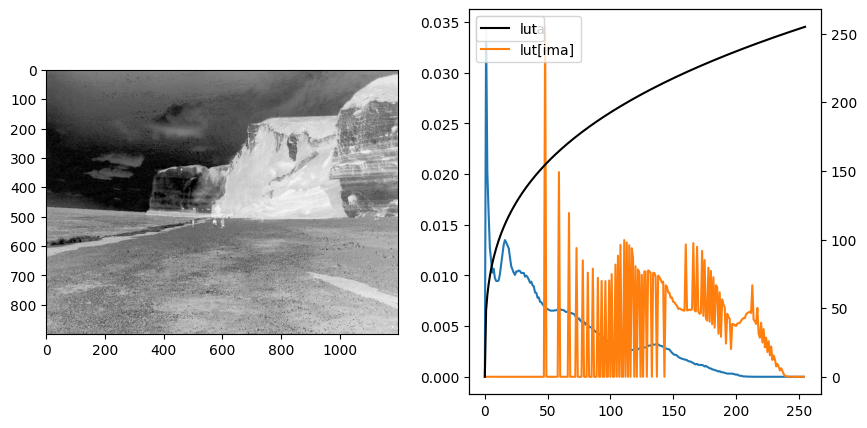

In [3]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage
from skimage.io import imread,imshow,imsave
from skimage.filters import gaussian, median

im = imread('etretat.jpg')

def norm_hist(ima):
    hist,bins = np.histogram(ima.flatten(),range(256))  # histogram is computed on a 1D distribution --> flatten()
    return 1.*hist/np.sum(hist) # normalized histogram

def apply_lut(ima,lut,vmin=None,vmax=None):
    ima *= 255
    ima = ima // 1
    nh = norm_hist(ima)
    lima = lut[ima.astype(int)]
    nh_lima = norm_hist(lima)
    
    plt.figure(figsize=[10,5])
    plt.subplot(1,2,1)
    plt.imshow(lima,cmap=cm.gray,vmin=vmin,vmax=vmax)
    ax1 = plt.subplot(1,2,2)
    plt.plot(nh,label='ima')
    plt.plot(nh_lima,label='lut[ima]')
    plt.legend(loc='upper left')
    ax2 = ax1.twinx()
    plt.plot(lut,label='lut',color='k')
    plt.legend()
    
    return lima
    
def lut_gamma(gamma):
    lut = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)
    return lut 

def PicsEnhancement(im, noise = False, autoLevel = False, gamma = True, gammaAuto = False, IncSat = False):
    Sat = .75
    gammaVal = 0.3
    
    if(IncSat): 
        print('Correction de la saturation en cours...')
        HSV_im = skimage.color.rgb2hsv(im)
        HSV_im[:,:,1] *= 1 + Sat
        im = skimage.color.hsv2rgb(HSV_im)

    if(noise):
        print('Correction du bruit en cours...')
        im = gaussian(im) 
        
    if(autoLevel):
        print('Correction des level en cours...')
        im = skimage.color.rgb2hsv(im)

        min = im[:,:,2].min()
        max = im[:,:,2].max()

        im[:,:,2] = 0 + (im[:,:,2]-min)*(1/(max-min))
        im = skimage.color.hsv2rgb(im)
         
    if(gamma): 
        print('Correction des gamma en cours...')
        HSV_im = skimage.color.rgb2hsv(im)
        
        changed = apply_lut(im[:,:,2],lut_gamma(gammaVal))
        im[:,:,2] = changed
        
        im = skimage.color.hsv2rgb(HSV_im)
          
    return im

PicsEnhancement(im)
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.imshow(im)
# plt.title("Original")
# plt.subplot(1,2,2)
# plt.imshow(PicsEnhancement(im))
# plt.title("Enhanced image")
# plt.show()


